## Using Residual Connections with MNIST

This notebook is training a deep CNN network with classifation layers for MNIST task.  Noise is added to the input, so this task is harder.  

The model is built with or without residual connections.  Recall that residual connections are essentially 'skip with add' connections.  The residual connections are used with an 'identity block' of 3 CNN layers, and the identity blocks are used to build up many layers.

1 Review the code blocks and identity blocks work, and notice how residual connections are built with them.

2 Run the code and observe results (Here the results are the output predictions. This is a classification task NOT an image reconstruction).

3 Add residual connections then rerun- do residual connections help classification?


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(20)

## Prepare the Dataset

In [2]:
#Load MNIST data from Keras datasets
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

X_train=X_train[0:1000,]  #only need smaller subset to get good results
Y_train=Y_train[0:1000,]

# --------- Reshape input data, b/c Keras expects N-3D images (ie 4D matrix)
X_train = X_train[:,:,:,np.newaxis]
X_test  = X_test[0:1000,:,:,np.newaxis]
Y_test  = Y_test[0:1000]
#Scale 0 to 1  - or should we not scale
X_train = X_train/255.0
X_test  = X_test/255.0

# ------------- End loading and preparing data --------------
print('X train shape:', X_train.shape) 
print('X test shape:', X_test.shape) 


X train shape: (1000, 28, 28, 1)
X test shape: (1000, 28, 28, 1)


In [3]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = tf.keras.utils.to_categorical(Y_train, 10)
Y_test  = tf.keras.utils.to_categorical(Y_test,  10)
Y_train.shape
Y_test.shape

(1000, 10)

In [4]:
#Add some noise to make it harder
def addnoise(X):
    X=X + np.round(np.random.uniform(-1,1,size=X.shape) )
    X[np.where(X>1)]=1
    X[np.where(X<0)]=0
    return X
X_train_wnoise = addnoise(X_train)
X_test_wnoise  = addnoise(X_test)
print('noise added')

noise added


## Define the functions to build the model

In [5]:
def identity_block(inputs,skipadd,count):
  '''Defines 3 layers, where input is added to last layer's output '''

  #the arrangement of filter sizes replicates the Deep Residual Learning (Resnet) paper, He etal 2015
  iconv_1 = tf.keras.layers.Conv2D(filters=16, kernel_size=(1,1), activation='relu', padding='same')(inputs)
  iconv_2 = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(iconv_1)
  iconv_3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), activation='relu', padding='same')(iconv_2)

  if skipadd:
      iconv_3 = tf.keras.layers.add([iconv_3,inputs],name='resid_conn_'+str(count))   #up_sample_2,conv_1])
    
  return iconv_3 



In [6]:
def build_model(use_skipadd,num2add):

  #create the first convolution layer
  inputs            = tf.keras.layers.Input(shape=(28, 28, 1,))
  conv_1     = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1) 
  next_block_inputs = max_pool_1
        
  #now add a series of identity blocks
  for i in range(0,num2add):
     next_block_inputs = identity_block(next_block_inputs,use_skipadd,i)   #_wskipadd(inputs)

  #now add classification layers
  block_flattened   = tf.keras.layers.Flatten()(next_block_inputs) 
  classifier_1      = tf.keras.layers.Dense(32,activation='relu')(block_flattened)
  classifier_output = tf.keras.layers.Dense(10,activation='softmax')(classifier_1)
  
  my_model         = tf.keras.Model(inputs =inputs, outputs=classifier_output)
  #my_model.summary()
  return my_model  


## Functions to display sample results

In [7]:
def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Display sample outputs in one row.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')


def display_results(disp_input_images,true_images, disp_predicted, enc_shape=(8,4)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  print(' ------ Test images followed by True Images before noise was added -------')
  display_one_row(disp_input_images, 0, shape=(28,28,))
  display_one_row(true_images, 20, shape=(28,28,))
  #display_one_row(disp_predicted, 20, shape=(28,28,))
  pres=list()
  print('------------ Output  Predictions -----------')
  for i in range(0,len(disp_predicted)):
        pres.append(np.argmax(disp_predicted[i,]))
  print(pres)


In [8]:
def show_results():
 # pick 10 indices
 idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

 # prepare test samples as a batch of 10 images
 conv_output_samples = np.array(X_test_wnoise[idxs])
 conv_output_samples = np.reshape(conv_output_samples, (10, 28, 28, 1))

 # get a prediction for some values in the dataset
 predicted = my_model.predict(conv_output_samples)
 print('------------ Output  True Class Values -----------')
 pres=list()
 for i in range(1,len(predicted)+1):
        pres.append(np.argmax(Y_test[i,]))
 print(pres)

 # display the samples, encodings and decoded values!
 display_results(conv_output_samples, X_test[idxs], predicted, enc_shape=(7,7))

# Build/run a model with and without skip-add ('residual') connections, and compare results



In [9]:
# -------------- First the model without skip-add connections ---------
myES_function = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)

numlayers=10   #<<<<<<<<--------------- use this number of 3-layer identity blocks, try a low (<3) and high (>8) range

my_model=build_model(False,numlayers)
my_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
my_model_history = my_model.fit(X_train_wnoise,Y_train, 
                                             validation_data=(X_test_wnoise,Y_test),
                                             batch_size=128,
                                             epochs=20,callbacks=[myES_function])


2023-08-09 21:11:49.970170: W tensorflow/stream_executor/platform/default/dso_loader.cc:65] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/.singularity.d/libs
2023-08-09 21:11:49.970207: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-09 21:11:49.970227: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (exp-4-13): /proc/driver/nvidia/version does not exist
2023-08-09 21:11:49.970378: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild T

Epoch 1/20
8/8 [==============================] - 2s 153ms/step - loss: 0.6688 - accuracy: 0.1020 - val_loss: 0.5793 - val_accuracy: 0.0870
Epoch 2/20
8/8 [==============================] - 1s 134ms/step - loss: 0.4960 - accuracy: 0.1080 - val_loss: 0.4228 - val_accuracy: 0.0990
Epoch 3/20
8/8 [==============================] - 1s 127ms/step - loss: 0.3995 - accuracy: 0.1050 - val_loss: 0.3767 - val_accuracy: 0.0890
Epoch 4/20
8/8 [==============================] - 1s 117ms/step - loss: 0.3606 - accuracy: 0.0780 - val_loss: 0.3517 - val_accuracy: 0.0990
Epoch 5/20
8/8 [==============================] - 1s 110ms/step - loss: 0.3425 - accuracy: 0.1170 - val_loss: 0.3377 - val_accuracy: 0.0990
Epoch 6/20
8/8 [==============================] - 1s 116ms/step - loss: 0.3330 - accuracy: 0.1170 - val_loss: 0.3314 - val_accuracy: 0.0990
Epoch 7/20
8/8 [==============================] - 1s 110ms/step - loss: 0.3286 - accuracy: 0.1170 - val_loss: 0.3292 - val_accuracy: 0.0990
Epoch 8/20
8/8 [====

1/1 [==============================] - 0s 192ms/step
------------ Output  True Class Values -----------
[2, 1, 0, 4, 1, 4, 9, 5, 9, 0]
 ------ Test images followed by True Images before noise was added -------
------------ Output  Predictions -----------
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7]


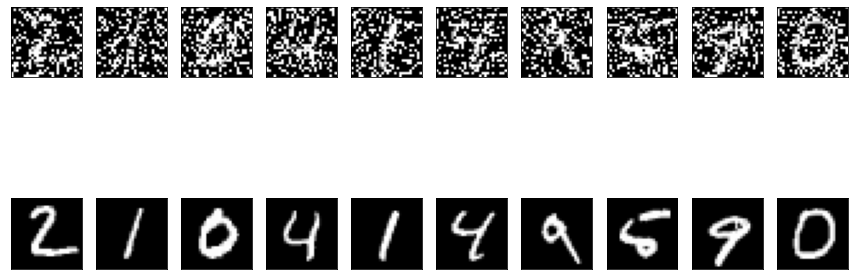

In [10]:
#Display some test data and predictions
show_results()



In [11]:
# --------------------- Now run the model with skip-add connections ---------
my_model=build_model(True,numlayers)
my_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
my_model_history = my_model.fit(X_train_wnoise,Y_train, 
                                             validation_data=(X_test_wnoise,Y_test),
                                             batch_size=128,
                                             epochs=20,callbacks=[myES_function])


Epoch 1/20
8/8 [==============================] - 2s 165ms/step - loss: 0.4759 - accuracy: 0.1160 - val_loss: 0.3625 - val_accuracy: 0.0940
Epoch 2/20
8/8 [==============================] - 1s 142ms/step - loss: 0.3559 - accuracy: 0.0850 - val_loss: 0.3455 - val_accuracy: 0.0890
Epoch 3/20
8/8 [==============================] - 1s 132ms/step - loss: 0.3409 - accuracy: 0.0930 - val_loss: 0.3385 - val_accuracy: 0.0870
Epoch 4/20
8/8 [==============================] - 1s 130ms/step - loss: 0.3349 - accuracy: 0.0940 - val_loss: 0.3318 - val_accuracy: 0.0870
Epoch 5/20
8/8 [==============================] - 1s 124ms/step - loss: 0.3295 - accuracy: 0.1160 - val_loss: 0.3293 - val_accuracy: 0.0890
Epoch 6/20
8/8 [==============================] - 1s 132ms/step - loss: 0.3265 - accuracy: 0.1030 - val_loss: 0.3263 - val_accuracy: 0.0930
Epoch 7/20
8/8 [==============================] - 1s 123ms/step - loss: 0.3239 - accuracy: 0.1850 - val_loss: 0.3243 - val_accuracy: 0.1260
Epoch 8/20
8/8 [====

1/1 [==============================] - 0s 181ms/step
------------ Output  True Class Values -----------
[2, 1, 0, 4, 1, 4, 9, 5, 9, 0]
 ------ Test images followed by True Images before noise was added -------
------------ Output  Predictions -----------
[2, 1, 0, 2, 1, 4, 6, 2, 7, 0]


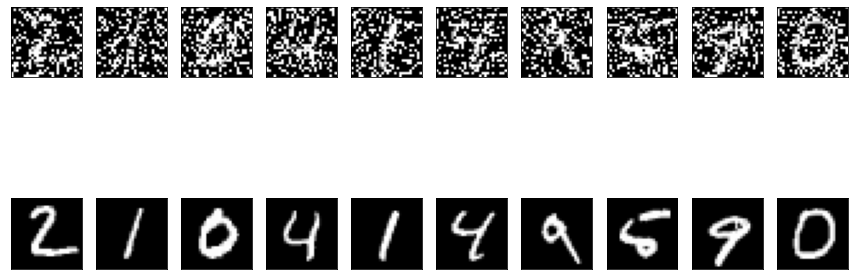

In [12]:
show_results()
